# Proxy Means Test (PMT)

The goal is to develop a predictive model to classify families correctly if they qualify for aid or not based on a dataset of Costa Rican household characteristics.

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Model building and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline

# For learning on imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb

# For model serialization
import pickle

import warnings
warnings.filterwarnings("ignore")

### Loading data into python environment

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Modifying the jupyter Notebook behavior to display ouptut of all lines of code not just the last one.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Exploratory Data Analysis (EDA) - Understanding dataset

In [4]:
# Checking dataset shape

train.shape
test.shape

(9557, 143)

(23856, 142)

KEY OBSERVATIONS:
- Training set has less number of observations/rows than the test dataset.
- The dataset has large number of columns 143 (train).
- Test dataset has only 142 columns. Response variable is not present in the test dataset and we can't use it to assess the acuracy of any model. It is to be used for prediction purpose.
- After going through the train.csv and test.csv files, 'Traget' appears to be the output variable. We can confirm the same by identifying the additional column present in training dataset.

In [5]:
# Confirming the additional variable present in train dataset is 'Target'

set(train.columns) - set(test.columns)

{'Target'}

In [6]:
# The dataset has large number of rows & columns. Modifying pandas display options to allow for inspection of large number of
# rows and columns in the output

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 150)

In [7]:
# Checking dtypes present

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


KEY OBSERVATIONS:
- There are 9557 rows (also found using shape method)
- There are 5 object type features/ columns.
- Similarly there are 130 int64 type and 8 float64 type columns in the dataset

In [8]:
# Check dtype of different features

train.dtypes

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
paredother           int64
pisomoscer           int64
pisocemento          int64
pisoother            int64
pisonatur            int64
pisonotiene          int64
pisomadera           int64
t

In [9]:
# Identifying the 'object' type features/columns

train.select_dtypes(include='object')

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no
...,...,...,...,...,...
9552,ID_d45ae367d,d6c086aa3,.25,9,no
9553,ID_c94744e07,d6c086aa3,.25,9,no
9554,ID_85fc658f8,d6c086aa3,.25,9,no
9555,ID_ced540c61,d6c086aa3,.25,9,no


KEY OBSERVATIONS:
- Two features 'Id' and 'idhogar' are identifiers and should be the object type only.
- Remaining three columns i.e. 'dependency', 'edjefe', 'edjefa' have mixed data i.e. contains both numeric as well as string type (yes/ no) data. 'yes' and 'no' need to be encoded approprirately then these features can be converted to numeric (int64 or float64) type.

In [10]:
# Idenfifying the float variables

train.select_dtypes(include='float64')

,v2a1,v18q1,rez_esc,meaneduc,overcrowding,SQBovercrowding,SQBdependency,SQBmeaned
0,190000.0,NaN,NaN,10.00,1.000000,1.000000,0.0000,100.0000
1,135000.0,1.0,NaN,12.00,1.000000,1.000000,64.0000,144.0000
2,NaN,NaN,NaN,11.00,0.500000,0.250000,64.0000,121.0000
3,180000.0,1.0,1.0,11.00,1.333333,1.777778,1.0000,121.0000
4,180000.0,1.0,NaN,11.00,1.333333,1.777778,1.0000,121.0000
...,...,...,...,...,...,...,...,...
9552,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9553,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9554,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625
9555,80000.0,NaN,NaN,8.25,1.250000,1.562500,0.0625,68.0625


KEY OBSERVATIONS:
- There are several NaN values. We need an effective strategy to handle these. This will be done later as part of data cleaning step.
- Some of the features are merely squared values such as SQBmeaned is squared value of meaneduc, similarly SQBdependency is squared value of dependency and SBQovercrowding is square of overcrowding.

In [11]:
# Checking summary statistics of numeric columns/ features

train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,1629.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.0,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,1.945066,0.399184,1.661714,2.060898,0.785079,3.220885,4.005964,3.999058,4.094590,7.200272,0.459791,3.999058,0.594015,0.077744,0.188030,0.008580,0.115622,0.013079,0.001465,0.001465,0.692791,0.222873,0.000942,0.001046,0.016428,0.065920,0.970074,0.017683,0.003139,0.002197,0.677409,0.964738,0.031705,0.003558,0.885110,0.000314,0.002197,0.110809,0.003872,0.213979,0.764257,0.015381,0.002511,0.001883,0.489589,0.458407,0.050120,0.882704,0.03003,0.084545,0.001465,0.0,0.001256,0.102438,0.327404,0.570158,0.128388,0.288061,0.583551,0.101078,0.252799,0.646123,0.057549,0.483415,0.516585,0.137805,0.123260,0.268390,0.031914,0.062781,0.033169,0.342681,0.311081,0.184054,0.381814,0.012138,0.009522,0.051167,0.010045,0.002407,0.013289,0.003139,0.012661,0.008685,1.406613,2.592445,0.284085,3.999058,9.231523,0.134666,0.170556,0.207701,0.185414,0.112692,0.017893,0.015591,0.139793,0.015381,2.739981,1.605380,0.61850,0.1

KEY OBSERVATIONS:
- Features/columns where the count is less than 9557, have null values. For instance, v2a1, v18q1 and so on.
- Several Features/columns have min of 0 and max of 1. These features are OneHotEndoded. It can be confirmed from the description provided in Data Fiels Description document (pdf). For ease of analysis and systematic exploration, we can separate them into one group.

In [12]:
# Creating a list of encoded features/variables

encoded_vars = []

for i in train.select_dtypes(include=['Int64', 'float64']).columns:
    if (((train[i].min() == 0) or (train[i].max() == 1)) and (train[i].nunique() <= 2)):
        encoded_vars.append(i)
    else:
        continue
        
len(encoded_vars)

102

Confirmed a list is created and includes 102 features/columns

#### One key aspect of the dataset. 

* The obvervation unit is family member AND NOT the family/household i.e. each row present data about individual household members. Therefore, if a household has say 6 members, ideally there should be 6 rows corresponding to each member of that household. 
* Further, each row has features/columns which capture data not at the individual family member level BUT at the household level (to which the member belongs). This implies, ideally the values of all features which capture household level data should be same for all family members belonging to one household. Simply put, features such as number of rooms in the household, household size/ tamhog, hhsize, refrig and so on will be same for all members belonging to one household. 
* In mathematical terms, the variance of such features (capturing household level data) should be ZERO for group of observations/ rows belonging to one household (unless there are data entry/capturing issues).

In [13]:
# To confirm the above, we groupby the data by 'idhogar'. 'idhogar' is the household ID. So grouping the data by 'idhogar' 
# will provide groups of all rows belonging to one household. For each group the variance of most features should be ZERO.

train.groupby(by='idhogar')[encoded_vars].var()

,hacdor,hacapo,v14a,refrig,v18q,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.00,0.000000,0.500000,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.500000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003123ec2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.250000,0.333333,0.333333,0.000000,0.0,0.000000,0.00,0.000000,0.250000,0.250000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.333333,0.0,0.250000,0.250000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004616164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.50,0.500000,0.500000,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.5,0.000000,0.000000,0.500000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
004983866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.0,0.000000,0.50,0.500000,0.500000,0.000000,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005905417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.000000,0.000000,0.0,0.333333,0.00,0.333333,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.333333,0.0,0.000000,0.333333,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

CONCLUSION: With above analysis, it appears to be partly processesed dataset with large number of columns. Further presence of squared variables suggest that feature engineering has also been done in this dataset. 

#### Check if there are any biases in your dataset

#### As per Google Foundational Course on Machine Learning (Link Below), there are several kind of bias that can be present in a dataset. Bias can be identified by looking into following:
            # Missing Feature Values
            # Unexpected Feature Values
            # Data Skew

#### To check for the existing bias in the dataset, let's sequentially check for each item
#### https://developers.google.com/machine-learning/crash-course/fairness/identifying-bias

#### Checking for Missing Feature Values

In [14]:
# Checking for Null values for encoded_vars

# Usualy, this can be done using train[encoded_vars].isna().sum(). However the number of features are too many to display in
# the output. So we will use the loop below to print the name of the columns with null values and also append these in a
# list

encoded_vars_with_Nulls = []

for i in encoded_vars:
    if train[i].isna().sum() != 0:
        print(i)
        encoded_vars_with_Nulls.append(i)

print(len(encoded_vars_with_Nulls))

0


As the length of the list is zero and no feature names are printed, we conclude that there are no Null Values in these encoded columns.

In [15]:
# Deleting encoded_vars_with_Nulls, as it is not required anymore.

del encoded_vars_with_Nulls

In [16]:
# Checking null values in features/columns which have'object' dtype
train.select_dtypes(include='object').isna().sum()

Id            0
idhogar       0
dependency    0
edjefe        0
edjefa        0
dtype: int64

Confirmed there are no Null Values. Earlier, we have noticed data inconsistency in three of these features. These will be handled as part of Data Cleaning/ preprocessing

In [17]:
# Checking null values in remaining features/columns. 
# Let's first create a list of all remaining feature names

remaining_vars = list(set(train.select_dtypes(include=['int64', 'float64']).columns)-set(encoded_vars))
len(remaining_vars)

36

There are 36 remaining variables to be checked for any Null values. remaining_vars (36) + encoded_vars (102) + object type (5) = total features (143)

In [18]:
# Checking for null/missing values in remaining_vars

train[remaining_vars].isna().sum().sort_values(ascending=False)

rez_esc            7928
v18q1              7342
v2a1               6860
meaneduc              5
SQBmeaned             5
SQBdependency         0
r4t2                  0
SQBedjefe             0
Target                0
age                   0
rooms                 0
tamhog                0
r4t1                  0
hogar_nin             0
r4m3                  0
hogar_total           0
r4h3                  0
SQBage                0
SQBhogar_total        0
r4h2                  0
r4t3                  0
r4m2                  0
r4m1                  0
escolari              0
SQBescolari           0
SQBhogar_nin          0
overcrowding          0
tamviv                0
SQBovercrowding       0
r4h1                  0
qmobilephone          0
hogar_adul            0
hhsize                0
hogar_mayor           0
agesq                 0
bedrooms              0
dtype: int64

Missing Featuer Values CONCLUSION - 
- v18q1, meaneduc, rez_esc, SQBmeaned, and v2a1 are five features with missing/Null values
- Within these five, v18q1, rez_esc and v2a1 are three features with very large number of Null values. In fact over 60-70% of values in these three columns are Null. THIS IS THE CASE OF BIAS FROM MISSING FEATURE VALUES.
- Further, for the two variables meaneduc and SQBmeaned only 5 missing values are there

Let's comeup with any appropriate strategy to fillnas in these features/columns. From the Data Fields Description document (pdf), we know:

- Dependency rate, calculated = (No. of members younger than 19 or older than 64)/ (# of household members between 19 and 64)
- No. of members younger than 19 or older than 64 = hogar_nin + hogar_mayor
- No. of members between 19 and 64 = hogar_total - (hogar_nin + hogar_mayor)
- So, we can approximate the dependency = (hogar_nin + hogar_mayor) / (hogar_total - hogar_nin - hogar_mayor)


In [19]:
# Before filling NaNs as above let's inspect these few features 

df = train[["dependency", 'hogar_nin', 'hogar_mayor', 'hogar_adul', 'hogar_total']].head(100)
df['dependency_calculated'] = (df['hogar_nin']+df['hogar_mayor'])/(df['hogar_total']-df['hogar_nin']-df['hogar_mayor'])
df[df['dependency'].isin(['yes', 'no'])].sort_values('dependency_calculated')

,dependency,hogar_nin,hogar_mayor,hogar_adul,hogar_total,dependency_calculated
0,no,0,0,1,1,0.0
82,no,0,0,3,3,0.0
81,no,0,0,3,3,0.0
80,no,0,0,3,3,0.0
60,no,0,0,2,2,0.0
59,no,0,0,2,2,0.0
40,no,0,0,2,2,0.0
31,no,0,0,2,2,0.0
30,no,0,0,2,2,0.0
26,no,0,0,1,1,0.0


KEY OBSERVATIONS: Based on the analysis of limited samples we can conclude following:
- dependency no = 0 and yes = 1
- Therefore, we can simply replace dependency yes = 1 and no = 0

Investigating the features edjefe and edjefa. 

Based on the Data Fields Description document for both these features yes = 1 and no = 0. Also, as per the description provided
- edjefe = years of education of the male head of household, based on the interaction of escolari (years of education),
head of household and gender, and 
- edjefa = years of education of the female head of household, based on the interaction of escolari (years of education), head of household and gender
- That is: edjefe (or edjefa) = escorali when parentesco1 == 1 and male == 1 (or female ==1)

In [20]:
# Check 1: edjefe == escorali    
train.loc[(train['male']==1) & (train["parentesco1"]==1)][['idhogar', 'edjefe', 'edjefa', 'escolari', 'parentesco1', 'male', 'female']].head()

# Check 2: edjefa == escorali
train.loc[(train['female']==1) & (train["parentesco1"]==1)][['idhogar', 'edjefe', 'edjefa', 'escolari', 'parentesco1', 'male', 'female']].head()

# Check3: edjefe (or edjefa) == Yes | No when escorali == 1 | 0 respectively
train.loc[((train['escolari'] == 0) | (train['escolari'] == 1)) & (train["parentesco1"]==1)][['idhogar', 'edjefe', 'edjefa', 'escolari', 'parentesco1', 'male', 'female']].head(20)

,idhogar,edjefe,edjefa,escolari,parentesco1,male,female
0,21eb7fcc1,10,no,10,1,1,0
1,0e5d7a658,12,no,12,1,1,0
5,2b58d945f,11,no,11,1,1,0
8,d6dae86b7,9,no,9,1,1,0
20,d29058053,15,no,15,1,1,0


,idhogar,edjefe,edjefa,escolari,parentesco1,male,female
2,2c7317ea8,no,11,11,1,0,1
12,bb2094100,no,11,11,1,0,1
13,c51f9c774,no,4,4,1,0,1
18,6893e65ca,no,10,10,1,0,1
40,922a1f87a,no,9,9,1,0,1


,idhogar,edjefe,edjefa,escolari,parentesco1,male,female
86,2b1a06ddc,no,no,0,1,0,1
124,d9e9b591a,no,no,0,1,0,1
171,71bec40bc,no,no,0,1,1,0
416,fd22b4607,no,no,0,1,1,0
432,39f697073,no,yes,1,1,0,1
498,7bf86807a,no,no,0,1,0,1
568,5f1665f1d,no,yes,1,1,0,1
595,10949c36b,no,yes,1,1,0,1
601,3641ce2d1,yes,no,1,1,1,0
635,fd10905bc,no,no,0,1,0,1


So we can simply replace yes = 1 and no = 0 for edjefe and edjefa

Inspecting v18q1.

In this regard note the following:
- v18q - owns a tablet, if v18q == 0, then household doesn't own a tablet
- v18q1 - number of tablets household owns
- Therefore, if a household doesn't own a table (v18q == 0) then v18q1 should be ZERO

In [21]:
# Checking for above condition

train[train['v18q'] == 0][['v18q', 'v18q1']]

# The number of rows with v18q == 0 is same as the number of Null values of v18q1.
# OR
    
train[train['v18q'] != 0]['v18q1'].isna().sum()
    
# v18q1 isn't Null if v18q is not equal to Zero i.e. if a household owns tablet then v18q1 is not null in the datasetb

,v18q,v18q1
0,0,NaN
2,0,NaN
7,0,NaN
8,0,NaN
9,0,NaN
...,...,...
9552,0,NaN
9553,0,NaN
9554,0,NaN
9555,0,NaN


0

Replace/Impute Null values for v18q1 with 0    

Inspecting 'rez_esc'

The Data Fields Document (pdf) provides following description of below features
- rez_esc - years behind in school
- escolari - years of schooling
- instlevel 1 - No level of education or uneducated 
- instlevel 3, 5, 7  - level of education is complete primary, academic secondary, and technical secondary respectively
- instlevel 2, 4, 6 - level of education is incomplete primary, academic secondary, and technical secondary respectively
- instlevel 8, 9 - level of education is undergraduate & higher and postgraduate higher respectively

In [22]:
# Inspecting observations where rez_esc is NaN.
train[train['rez_esc'].isna()][['Id', 'idhogar', 'escolari', 'rez_esc', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']].head(10)

# Inspecting observations where rez_esc is not Null
train[~train['rez_esc'].isna()][['Id', 'idhogar', 'escolari', 'rez_esc', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']].head(10)

,Id,idhogar,escolari,rez_esc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,ID_279628684,21eb7fcc1,10,NaN,0,0,0,1,0,0,0,0,0
1,ID_f29eb3ddd,0e5d7a658,12,NaN,0,0,0,0,0,0,0,1,0
2,ID_68de51c94,2c7317ea8,11,NaN,0,0,0,0,1,0,0,0,0
4,ID_d56d6f5f5,2b58d945f,11,NaN,0,0,0,0,1,0,0,0,0
5,ID_ec05b1a7b,2b58d945f,11,NaN,0,0,0,0,1,0,0,0,0
8,ID_1284f8aad,d6dae86b7,9,NaN,0,0,0,1,0,0,0,0,0
9,ID_51f52fdd2,d6dae86b7,11,NaN,0,0,0,0,1,0,0,0,0
11,ID_de822510c,bb2094100,12,NaN,0,0,0,0,0,0,1,0,0
12,ID_d94071d7c,bb2094100,11,NaN,0,0,0,0,1,0,0,0,0
13,ID_064b57869,c51f9c774,4,NaN,0,1,0,0,0,0,0,0,0


,Id,idhogar,escolari,rez_esc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
3,ID_d671db89c,2b58d945f,9,1.0,0,0,0,1,0,0,0,0,0
6,ID_e9e0c1100,2b58d945f,2,0.0,0,1,0,0,0,0,0,0,0
7,ID_3e04e571e,d6dae86b7,0,0.0,1,0,0,0,0,0,0,0,0
10,ID_db44f5c59,d6dae86b7,3,1.0,0,1,0,0,0,0,0,0,0
38,ID_0f01e18e9,cbf24a06c,8,0.0,0,0,0,1,0,0,0,0,0
42,ID_e3869ade2,a57a1f2f4,8,0.0,0,0,0,1,0,0,0,0,0
48,ID_839160e1d,6ddd55b3e,2,0.0,0,1,0,0,0,0,0,0,0
50,ID_eb1d477b3,652a7ffa0,2,0.0,0,1,0,0,0,0,0,0,0
52,ID_68cdfd374,652a7ffa0,8,0.0,0,0,0,1,0,0,0,0,0
54,ID_88d6dc9be,b9d64d752,6,0.0,0,0,1,0,0,0,0,0,0


KEY OBSERVATIONS:
- There may not be any relationship (that can be expressed as a equation) between rez_esc and other features related to schooling duration.
- Even if there is a relationship, it is difficult to decipher without additional information about the features and dataset.
- Due to this, it will be most prudent to fill these NaN with most frequent or median value of rez_esc.

In [23]:
# Checking unique values and their respective counts for feature rez_esc
train['rez_esc'].value_counts()

rez_esc
0.0    1211
1.0     227
2.0      98
3.0      55
4.0      29
5.0       9
Name: count, dtype: int64

Note that rez_esc values range from 0.0 to maximum of 5.0 with 0 being the most common. We can fill rez_esc NaNs with Zero as this is most frequently occuring value

Inspecting the feature 'v2a1' - Monthly rent payment
From Data Fields Description document (pdf), it is clear:
- 'tipoviv1' and 'tipoviv2' - house is completely or partly owned (paying installments) by the family/househod
- tipovivi3 - house is rented
- tipovivi4 - house is precarious - Perhaps here it can be understood as a not-permanent/ makeshift kind of home. Without
additional information or understanding of dataset, this presumption has to be accepted.
- tipovivi5 - house is in others category (assigned/ borrowed)

In [24]:
# Checking how many such rented houses are there where Monthly Rent payment (v2a1) is not known/ is Null.

train[train['tipovivi3'] == 1]['v2a1'].isna().sum()

0

For all rented houses, v2a1 is non-Null. In other words all Null values of v2a1 are for non-rented houses.

In [25]:
# Let's further inspect the v2a1 variable

# Below is the slice of the train dataset where v2a1 is non-Null and house is not rented.
train.loc[(~train['v2a1'].isna()) & (train['tipovivi3'] == 0)][['v2a1', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4']]

,v2a1,tipovivi1,tipovivi2,tipovivi3,tipovivi4
11,100000.0,0,1,0,0
12,100000.0,0,1,0,0
74,350000.0,0,1,0,0
75,350000.0,0,1,0,0
76,350000.0,0,1,0,0
...,...,...,...,...,...
9545,46500.0,0,1,0,0
9546,46500.0,0,1,0,0
9547,46500.0,0,1,0,0
9548,46500.0,0,1,0,0


There are 961 such rows and it appears these are for houses which are partly owned, and paying in installments.

In [26]:
# Further with the below code lines we can confirm all 961 cases belong to category where tipovivi2 == 1.

len(train.loc[(~train['v2a1'].isna()) & (train['tipovivi2'] == 1)])
len(train.loc[(train['v2a1'].isna()) & (train['tipovivi2'] == 1)])
len(train.loc[(train['v2a1'].isna()) & (train['tipovivi3'] == 0)])

961

0

6860

CONCLUSIONS:
- Therefore, it appears the monthly installment being paid is captured as v2a1 i.e. Monthly rent payment for houses in category 'tipovivi2'.
- Clearly Total obserstaions (9557) = No. of observations for rented houses (1736) + No. of observations for non-rented houses with non-Null v2a1 (961) + No. of observations for non-rented houses with Null v2a1 (6860): set NaN as Median 
- Hence the strategy to fill Null values is as below:
    * Houses in category 'tipovivi2': set NaN as Median v2a1 of this group
    * Houses in category 'tipovivi1', 'tipovivi4' and 'tipovivi5': Set NaN  as Zero
    * Houses in category 'tipovivi3': There are no Null values. If present, these can be set equal to the mean/median Monthly rent for this group

In [27]:
# Inspecting meaneduc and SQBmeaned

train[train['meaneduc'].isna()][['idhogar', 'meaneduc', 'SQBmeaned']]
train[train['idhogar'].isin(list(train[train['meaneduc'].isna()]['idhogar']))][["idhogar", "age", "escolari"]]

,idhogar,meaneduc,SQBmeaned
1291,1b31fd159,NaN,NaN
1840,a874b7ce7,NaN,NaN
1841,a874b7ce7,NaN,NaN
2049,faaebf71a,NaN,NaN
2050,faaebf71a,NaN,NaN


,idhogar,age,escolari
1291,1b31fd159,18,10
1840,a874b7ce7,18,6
1841,a874b7ce7,18,4
2049,faaebf71a,19,12
2050,faaebf71a,19,12


KEY OBSERVATIONS:
- For 5 members belonging to three households the meaneduc and SQBmeaned values are Null
- Based on Data Fields Description document it can be said: meaneduc = mean escolari for all members belonging to a household if age >= 18
- So for 1b31fd159 (meaneduc) = 10, a874b7ce7 (meaneduc) = (6+4)/2 = 5, and faaebf71a (meaneduc) = (12+12)/2 = 12
- Thefore the strategy to fill NaNs is to set the value as computed above for three households

#### Checking for unexpected feature values/ data inconsistencies

In [28]:
# Checking for unexpected values in encoded_vars.

for i in train[encoded_vars]:
    print(train[i].value_counts())
    print("\n")


hacdor
0    9193
1     364
Name: count, dtype: int64


hacapo
0    9331
1     226
Name: count, dtype: int64


v14a
1    9507
0      50
Name: count, dtype: int64


refrig
1    9152
0     405
Name: count, dtype: int64


v18q
0    7342
1    2215
Name: count, dtype: int64


paredblolad
1    5677
0    3880
Name: count, dtype: int64


paredzocalo
0    8814
1     743
Name: count, dtype: int64


paredpreb
0    7760
1    1797
Name: count, dtype: int64


pareddes
0    9475
1      82
Name: count, dtype: int64


paredmad
0    8452
1    1105
Name: count, dtype: int64


paredzinc
0    9432
1     125
Name: count, dtype: int64


paredfibras
0    9543
1      14
Name: count, dtype: int64


paredother
0    9543
1      14
Name: count, dtype: int64


pisomoscer
1    6621
0    2936
Name: count, dtype: int64


pisocemento
0    7427
1    2130
Name: count, dtype: int64


pisoother
0    9548
1       9
Name: count, dtype: int64


pisonatur
0    9547
1      10
Name: count, dtype: int64


pisonotiene
0    9400
1  

For encoded_vars all values are either 0 or 1. So there are no unexpcted values found.

In [29]:
# For object dtypes, we have already seen few inconsistent values (Yes, and No) present in some columns 

for i in train[['dependency', 'edjefe', 'edjefa']]:
    print(train[i].value_counts())
    print("\n")

dependency
yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
.40000001      84
1.3333334      84
2.5            77
5              24
1.25           18
3.5            18
.80000001      18
2.25           13
.71428573      12
1.75           11
1.2            11
.83333331      11
.22222222      11
.2857143        9
1.6666666       8
.60000002       8
6               7
.16666667       7
Name: count, dtype: int64


edjefe
no     3762
6      1845
11      751
9       486
3       307
15      285
8       257
7       234
5       222
14      208
17      202
2       194
4       137
16      134
yes     123
12      113
10      111
13      103
21       43
18       19
19       14
20        7
Name: count, dtype: int64


edjefa
no     6230
6       947
11      399
9       237
8       217
15      188
7       179
5       176
3

- Apart from 'yes' and 'no' values mentioned above there are no unexptected values found. All other values are numeric. 
- edjefe and edjefa values range from 0 to 21.

NOTE - Unexpected values can take several forms and their detection would rely heavily on the skill/ understanding about data collection methods/ domain knowledge of the data scientist. Few common ways in which unexpected value manifest are:
* Non-numeric values for numeric variables,
* -ve values when it is not possible e.g. -ve age, -ve number of rooms in a house and so on
* Values outside a permissible range/set e.g. 8 as number of COVID Vaccine doses received by a healthy person etc.
    
For numeric varaibles (remaining_vars), if any rules such as a valid value range for a variable are know then we can verify if the observed values follow the rule or not. However no such rules are avaiable here.    

In [30]:
# Checking the min and max values for different variables.

train[remaining_vars].describe()

,SQBdependency,r4m1,agesq,meaneduc,hogar_mayor,hhsize,hogar_adul,v18q1,qmobilephone,r4h1,SQBovercrowding,tamviv,overcrowding,SQBhogar_nin,SQBescolari,SQBmeaned,v2a1,escolari,r4t3,r4m2,r4t1,r4h2,SQBedjefe,rez_esc,Target,age,rooms,r4t2,tamhog,hogar_nin,r4m3,hogar_total,r4h3,SQBage,SQBhogar_total,bedrooms
count,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,1629.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000
mean,3.900409,0.399184,1643.774302,9.231523,0.284085,3.999058,2.592445,1.404063,2.821492,0.385895,3.249485,4.094590,1.605380,3.844826,74.222769,102.588867,1.652316e+05,7.200272,4.005964,1.661714,0.785079,1.559171,53.500262,0.459791,3.302292,34.303547,4.955530,3.220885,3.999058,1.406613,2.060898,3.999058,1.945066,1643.774302,19.132887,2.739981
std,12.511831,0.692460,1741.197050,4.167694,0.597163,1.772216,1.166074,0.763131,1.483249,0.680779,4.129547,1.876428,0.819946,6.946296,76.777549,93.516890,1.504571e+05,4.730877,1.771202,0.933052,1.047559,1.036574,78.445804,0.946550,1.009565,21.612261,1.468381,1.440995,1.772216,1.366185,1.206172,1.772216,1.188852,1741.197050,18.751395,0.944507
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.040000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,0.111111,0.000000,289.000000,6.000000,0.000000,3.000000,2.000000,1.000000,2.000000,0.000000,1.000000,3.000000,1.000000,0.000000,16.000000,36.000000,8.000000e+04,4.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,17.000000,4.000000,2.000000,3.000000,0.000000,1.000000,3.000000,1.000000,289.000000,9.000000,2.000000
50%,0.444444,0.000000,961.000000,9.000000,0.000000,4.000000,2.000000,1.000000,3.000000,0.000000,2.250000,4.000000,1.500000,1.000000,36.000000,81.000000,1.300000e+05,6.000000,4.000000,1.000000,0.000000,1.000000,36.000000,0.000000,4.000000,31.000000,5.000000,3.000000,4.000000,1.000000,2.000000,4.000000,2.000000,961.000000,16.000000,3.000000
75%,1.777778,1.000000,2601.000000,11.600000,0.000000,5.000000,3.000000,2.000000,4.000000,1.000000,4.000000,5.000000,2.000000,4.000000,121.000000,134.560010,2.000000e+05,11.000000,5.000000,2.000000,1.000000,2.000000,81.000000,1.000000,4.000000,51.000000,6.000000,4.000000,5.000000,2.000000,3.000000,5.000000,3.000000,2601.000000,25.000000,3.000000
max,64.000000,6.000000,9409.000000,37.000000,3.000000,13.000000,9.000000,6.000000,10.000000,5.000000,36.000000,15.000000,6.000000,81.000000,441.000000,1369.000000,2.353477e+06,21.000000,13.000000,6.000000,7.000000,8.000000,441.000000,5.000000,4.000000,97.000000,11.000000,11.000000,13.000000,9.000000,8.000000,13.000000,8.000000,9409.000000,169.000000,8.000000


- There are no -ve values observed for any of the variables.
- The maximum age is 97 which is a valid value.

#### Checking for Data Skew

In [31]:
#  Taking value_counts() on the output variable 'Target' to find how balanced is the dataset.

train["Target"].value_counts()

Target
4    5996
2    1597
3    1209
1     755
Name: count, dtype: int64

KEY OBSERVATIONS:
- There are four class labels. So we have a multi-class classification problem at hand
- The dataset is imbalanced one, as we have too many samples for class 4 and comparatively fewer samples for class 1.

In [32]:
# Class imbalance in % terms

Series1 = train.Target.value_counts()
Series1.index.name = 'Class'
Series1 = Series1.reset_index()
Series2 = pd.Series([round((i/train.Target.value_counts().sum())*100, 1) for i in train.Target.value_counts()], name='Target_%')
df_class_balance = pd.concat([Series1, Series2], axis=1)
df_class_balance

,Class,count,Target_%
0,4,5996,62.7
1,2,1597,16.7
2,3,1209,12.7
3,1,755,7.9


KEY OBSERVATION: Only 7.9% of samples belong to class 1 i.e. approximately 1:8 ratio with number of samples for class 4

<Figure size 600x600 with 0 Axes>

Text(0.0, 855.0, '7.9%\n')

Text(1.0, 1697.0, '16.7%\n')

Text(2.0, 1309.0, '12.7%\n')

Text(3.0, 6096.0, '62.7%\n')

Text(0.5, 1.0, 'Class Distributions')

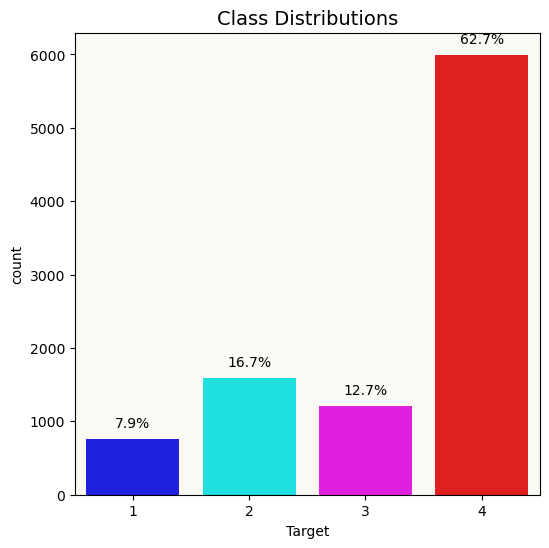

In [33]:
# Visualising class imbalance

colors = ["blue", "cyan", "magenta", "red"]
Total = len(train.Target)

plt.figure(figsize=(6,6))
ax = sns.countplot(x ='Target', data=train, palette=colors)
ax.set_facecolor('#faf9f4')
for p in ax.patches:
    percentage = f'{100 * p.get_height() / Total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 100
    
    ax.annotate(percentage, (x, y), ha='center', va='center')
    
plt.title('Class Distributions', fontsize=14)

KEY OBSERVATIONS: There is several type of bias present in the dataset. Most important ones are:
- Large number of missing values present for few variables - rez_esc, v18q1, v2a1
- inconsistent values present in few variables - dependency, edjefe and edjefa
- imbalace in terms of number of samples present for each class. Class label 4 is over represented.

#### Data Cleaning and Prepration
* Handling Missing/ Null Values

In [34]:
# Creating a function data_clearner() to address the issues observed as part of exploratory data analysis.
# Creating a data cleaner function, allows us to call it to clean the test data before making prediction using the model

def data_cleaner(df):
    
    X = df.copy()  # Creating copy of df to ensure, any of the operations don't alter original dataset
     
    # Cleaning 'object' dtype variables; replacing 'yes' with 1 and 'no' with 0
    X["dependency"].replace('yes', 1, inplace = True)
    X["dependency"].replace('no', 0, inplace = True)
    
    X["edjefe"].replace('yes', 1, inplace = True)
    X["edjefe"].replace('no', 0, inplace = True)
    
    X["edjefa"].replace('yes', 1, inplace = True)
    X["edjefa"].replace('no', 0, inplace = True)
    
    
    # Cleaning remaining_vars
    X.loc[X['v18q'] == 0, 'v18q1'] = X.loc[X['v18q'] == 0, 'v18q1'].fillna(0)
    
    # Alternatively (if it is certain that all NaN values for v18q1 occur when v18q == 0):
    # X['v18q1'].fillna(0, inplace=True)
    
    
    X['rez_esc'].fillna(X['rez_esc'].mode()[0], inplace=True)
    
    
    # Using np.select to fill NaNs in v2a1 based on multiple conditions in different columns
    conditions = [X['tipovivi1'].eq(1) & X['v2a1'].isnull(),
                  X['tipovivi4'].eq(1) & X['v2a1'].isnull(),
                  X['tipovivi5'].eq(1) & X['v2a1'].isnull(),
                  X['tipovivi2'].eq(1) & X['v2a1'].isnull(),
                  X['tipovivi3'].eq(1) & X['v2a1'].isnull() & X['lugar1'].eq(1),
                  X['tipovivi3'].eq(1) & X['v2a1'].isnull() & X['lugar2'].eq(1),
                  X['tipovivi3'].eq(1) & X['v2a1'].isnull() & X['lugar3'].eq(1),
                  X['tipovivi3'].eq(1) & X['v2a1'].isnull() & X['lugar4'].eq(1),
                  X['tipovivi3'].eq(1) & X['v2a1'].isnull() & X['lugar5'].eq(1),
                  X['tipovivi3'].eq(1) & X['v2a1'].isnull() & X['lugar6'].eq(1)
                 ]
    
    choices = [0,
               0,
               0,
               X.loc[X['tipovivi2']==1, 'v2a1'].mode()[0],
               X.loc[((X['tipovivi3']==1) & (X['lugar1']==1)), 'v2a1'].mode()[0],
               X.loc[((X['tipovivi3']==1) & (X['lugar2']==1)), 'v2a1'].mode()[0],
               X.loc[((X['tipovivi3']==1) & (X['lugar3']==1)), 'v2a1'].mode()[0],
               X.loc[((X['tipovivi3']==1) & (X['lugar4']==1)), 'v2a1'].mode()[0],
               X.loc[((X['tipovivi3']==1) & (X['lugar5']==1)), 'v2a1'].mode()[0],
               X.loc[((X['tipovivi3']==1) & (X['lugar6']==1)), 'v2a1'].mode()[0]
              ]
    
    X['v2a1'] = np.select(conditions, choices, default = X['v2a1'])
    
    
    # Handling NaNs in the meaneduc. Filling up NaNs here involve complex steps.
    # First Step: Creating a dataframe with 'idhogar' and 'meaneduc' == mean('escolari') for adults in a household
    df1 = X[X['age'] >= 18].groupby('idhogar', as_index = False)['escolari'].mean()
    df1['meaneduc'] = df1['escolari']
    df1.drop('escolari', axis=1, inplace = True)
    
    # Second Step: Creating a dataframe with 'idhogar' and 'meaneduc' as provided in the data for households where there 
    # are no adults.
    df2 = X.groupby('idhogar', as_index=False).filter(lambda x: (x['age'] < 18).all())[['idhogar', 'meaneduc']].drop_duplicates()
    
    # Third Step : Concatenating the two ealier dataframes to get one combined df with all 'idhogar' and 'meaneduc'
    df = pd.concat([df1, df2], axis=0)
    
    # Step Fourth: Converting the df into a dictionary and mapping the values to create a new columns 'meaneduc_new' 
    mapping_dict = dict(zip(df['idhogar'], df['meaneduc']))
    X['meaneduc_new'] = X['idhogar'].map(mapping_dict)
    
    # Step Fifth: Finallly filling up the NaNs in 'meaneduc' with values in new series 'meaneduc_new'. Deleteing the columns
    # after fillna operation
    X['meaneduc'].fillna(X['meaneduc_new'], inplace=True)
    X.drop('meaneduc_new', axis=1, inplace=True)
    
    # Lastly handling NaNs in SQBmeaned
    X['SQBmeaned'].fillna(X['meaneduc']**X['meaneduc'], inplace=True)
    
        
    # Converting dependency, edjefe and edjefa to int64/ float64
    X['edjefe'] = X['edjefe'].astype('int64')
    X['edjefa'] = X['edjefa'].astype('int64')
    X['dependency'] = X['dependency'].astype('float64') 
    
    
    # FINALLY, TO BE 100% SURE THERE ARE NO NANs LEFT IN THE DATASET:
    X.dropna(inplace=True)
    # AND, RESETTING THE INDEX
    X.reset_index(inplace=True, drop=True)
        
    return X

In [35]:
# Cleaning data by calling data_cleaner()
X0 = data_cleaner(train)

In [36]:
# Confirm, if the dataset is cleaned or not.

X0.isna().sum()
X0.dtypes
X0[X0['edjefe'].isin(['yes', 'no'])]
X0[X0['edjefa'].isin(['yes', 'no'])]
X0[X0['dependency'].isin(['yes', 'no'])]

Id                 0
v2a1               0
hacdor             0
rooms              0
hacapo             0
v14a               0
refrig             0
v18q               0
v18q1              0
r4h1               0
r4h2               0
r4h3               0
r4m1               0
r4m2               0
r4m3               0
r4t1               0
r4t2               0
r4t3               0
tamhog             0
tamviv             0
escolari           0
rez_esc            0
hhsize             0
paredblolad        0
paredzocalo        0
paredpreb          0
pareddes           0
paredmad           0
paredzinc          0
paredfibras        0
paredother         0
pisomoscer         0
pisocemento        0
pisoother          0
pisonatur          0
pisonotiene        0
pisomadera         0
techozinc          0
techoentrepiso     0
techocane          0
techootro          0
cielorazo          0
abastaguadentro    0
abastaguafuera     0
abastaguano        0
public             0
planpri            0
noelec       

Id                  object
v2a1               float64
hacdor               int64
rooms                int64
hacapo               int64
v14a                 int64
refrig               int64
v18q                 int64
v18q1              float64
r4h1                 int64
r4h2                 int64
r4h3                 int64
r4m1                 int64
r4m2                 int64
r4m3                 int64
r4t1                 int64
r4t2                 int64
r4t3                 int64
tamhog               int64
tamviv               int64
escolari             int64
rez_esc            float64
hhsize               int64
paredblolad          int64
paredzocalo          int64
paredpreb            int64
pareddes             int64
paredmad             int64
paredzinc            int64
paredfibras          int64
paredother           int64
pisomoscer           int64
pisocemento          int64
pisoother            int64
pisonatur            int64
pisonotiene          int64
pisomadera           int64
t

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


- There are no Null Values/ NaNs
- dependency, edjefe and edjefa are all converted to appropriate dtype
- There  are no rows with 'yes'/ 'no' value for edjefe
- There  are no rows with 'yes'/ 'no' value for edjefa
- There  are no rows with 'yes'/ 'no' value for dependency

#### Handling outliers

A key data preprocessing step (required for many ML models) is to treat outliers. However for the dataset in consideration removing/ droping outliers will not be appropriate. In every society there are people who would fall at the ends of poverty to wealthiness spectrum. The very objective of the exercise if to correctly classify households based on their poverty level so that appropriate level of aid/support can be provided. In this context droping outlier households would mean removing the most needy and/or most wealthy from the dataset.
    
HENCE THE OUTLIER'S WILL BE LEFT AS IS.

####  Check if all members of a household have the same poverty level.

NOTE: The ouput variable Target is an ordinal variable indicating groups of income/ poverty levels
* 1 = extreme poverty
* 2 = moderate poverty
* 3 = vulnerable households
* 4 = non vulnerable households

In order to check, if the poverty level of all household members is same or not, we will groupby train by = 'idhogar' and then check if the min and max value of Target/ povertly level is same for each idhogar group or not. If the Poverty Level of different members in the same household is different the min and max values will be different (i.e. will not be same).

In [37]:
# Creating a dataframe by households with min, max, mean and median values of 'Target' for the household.

df = X0.groupby('idhogar')['Target'].agg([np.min, np.max, np.mean, np.median])
df[(df['min'] != df['max'])]  # Taking a slice of the df where min and max is not same. 
df[(df['min'] != df['max'])].shape[0]

,min,max,mean,median
idhogar,,,,
0172ab1d9,2,3,2.600000,3.0
03f4e5f4d,1,2,1.333333,1.0
0511912b6,3,4,3.750000,4.0
078a0b6e2,1,2,1.500000,1.5
09e25d616,1,2,1.750000,2.0
0f3e65c83,1,2,1.333333,1.0
0f9494d3a,2,3,2.600000,3.0
15a891635,1,2,1.666667,2.0
17fb04a62,1,2,1.333333,1.0


85

In [38]:
# Alternatively, we can get the same result by using below line of code

# Here df is a dataframe including all groups (i.e. households) where min and max value of the Target is not same/equal. 
# In other words Target values are not same for all members of the household

df = X0.groupby('idhogar').filter(lambda x: x['Target'].min() != x['Target'].max())['idhogar'].drop_duplicates() 
len(df)

85

There are 85 such households where poverty level of all household members is not same. These households are identified by 'idhogar' present in df OR the index of df

#### Check if there is a house without a family head.

To check this, we will groupby the dataset by='idhogar' and filter all the groups/households where all members has parentesco1 == 0 (OR not even one member of the household has parentesco == 1)

In [39]:
df = X0.groupby('idhogar').filter(lambda x: (x['parentesco1'] == 0).all())['idhogar'].drop_duplicates()
len(df)

15

In [40]:
# Confirming households in df have no household head
df = X0.loc[(X0['idhogar'].isin(list(df))) & (X0['parentesco1'] == 1)]
df
df.shape

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


(0, 143)

There are 15 household (as indicated by df) where there is no household head

Before model building, setting the poverty level of the members and the head of the house within a family.

Setting the poverty level of the members: We can take different approaches to set the same level of poverty for all members within a household. These are:
- Poverty level for all members within a household can be set same as that of it's head. In this case, we will have to separately deal with households without a head.
- Poverty level for all memebers within a household can be set same as the most common (i.e. Mode) level for that household. In this case, we might have to check and handle separately any cases if the poverty level of a household is Null.

In [41]:
# Using pandas groupby().transform() to overwrite 'Target' feature with the most frequent (mode value) of Target for the 
# household.

X0['Target'] = X0.groupby('idhogar')['Target'].transform(lambda x: x.mode()[0])

In [42]:
# Confirm if same poverty level for all members of household is set or not.

df = X0.groupby('idhogar').filter(lambda x: x['Target'].min() != x['Target'].max())['idhogar'].drop_duplicates() 
len(df)

0

Confirmed now there are no households where Target value for all members is not same.

Setting the head of the house within a household
- For the households where there is no household head, we can assign the eldest member as household head.
- For all other cases, household head should remain unchanged

In [43]:
# Step 1 - filter the rows of dataset which correspond to households without a head
df = X0.groupby('idhogar').filter(lambda x: (x['parentesco1'] == 0).all())
df

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
4935,ID_717302050,0.0,0,8,0,1,1,0,0.0,0,2,2,0,2,2,0,4,4,4,4,6,0.0,4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,09b195e7a,2,2,0,4,1.000000,6,0,6.000000,0,0,1,0,0,0,0,0,0,5,0.800000,1,0,0,0,0,0,1,1,4,1,0,0,0,0,0,0,1,34,36,1156,16,36,4,0.640000,1.000000,36.000000,1156,3
4975,ID_ff6f13458,0.0,0,4,0,1,1,0,0.0,1,1,2,0,2,2,1,3,4,4,4,9,0.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,896fe6d3e,2,2,0,4,1.000000,9,0,7.500000,0,0,0,0,0,1,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,16,81,256,16,81,4,4.000000,1.000000,56.250000,256,3
5391,ID_64c9eabac,0.0,0,5,0,1,1,0,0.0,0,1,1,0,2,2,0,3,3,3,3,14,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,61c10e099,0,3,0,3,0.000000,6,0,8.666667,0,0,0,0,0,0,0,1,0,3,1.000000,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,20,196,400,9,36,0,1.000000,0.000000,75.111115,400,3
5396,ID_8948b1f91,90000.0,0,5,0,1,1,0,0.0,2,1,3,1,1,2,3,2,5,5,5,3,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,374ca5a19,3,2,0,5,1.500000,6,0,8.500000,0,1,0,0,0,0,0,0,0,3,1.666667,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,0,1,10,9,100,25,36,9,2.777778,2.250000,72.250000,100,3
6443,ID_8ddb34d2c,0.0,0,3,0,1,1,0,0.0,1,1,2,0,2,2,1,3,4,4,4,0,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3,0,6.000000,1,0,0,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,7,0,49,16,9,4,4.000000,1.000000,36.000000,49,3
6444,ID_03e2f23b0,0.0,0,3,0,1,1,0,0.0,1,1,2,0,2,2,1,3,4,4,4,6,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,bfd5067c2,2,2,0,4,1.000000,3,0,6.000000,0,0,1,0,0,0,0,0,0,2,2.000000,1,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,13,36,169,16,9,4,4.000000,1.000000,36.000000,169,3
7086,ID_ba2ac56bb,0.0,0,4,0,1,1,0,0.0,0,1,1,2,2,4,2,3,5,5,5,11,0.0,5,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1367ab31d,3,2,0,5,1.500000,16,0,18.000000,0,0,0,0,1,0,0,0,0,2,2.500000,1,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,1,19,121,361,25,256,9,6.250000,2.250000,324.000000,361,3
7438,ID_7ba374a80,0.0,0,4,0,1,1,0,0.0,0,3,3,0,1,1

In [44]:
# Step 2 - For each household, filter the row where the member has highest/ maximum age
df.groupby('idhogar').age.idxmax()

# Then use these row index values to set the 'parentesco1' = 1, as below
X0.loc[df.groupby('idhogar').age.idxmax(), 'parentesco1'] = 1


idhogar
03c6bdf85    7705
09b195e7a    4935
1367ab31d    7086
1bc617b23    9497
374ca5a19    5396
61c10e099    5391
6b1b2405f    7438
896fe6d3e    4975
a0812ef17    8636
ad687ad89    7756
b1f4d89d7    7757
bfd5067c2    6444
c0c8a5013    8432
d363d9183    9489
f2bfa75c4    7463
Name: age, dtype: int64

In [45]:
# Confirm is there still any household without head

df = X0.groupby('idhogar').filter(lambda x: (x['parentesco1'] == 0).all())
df.shape

(0, 143)

Poverty level and household head have been set wherever discrepencies were observed

In [46]:
# Check if any Null values are present in dataset now
X0.isna().sum()

Id                 0
v2a1               0
hacdor             0
rooms              0
hacapo             0
v14a               0
refrig             0
v18q               0
v18q1              0
r4h1               0
r4h2               0
r4h3               0
r4m1               0
r4m2               0
r4m3               0
r4t1               0
r4t2               0
r4t3               0
tamhog             0
tamviv             0
escolari           0
rez_esc            0
hhsize             0
paredblolad        0
paredzocalo        0
paredpreb          0
pareddes           0
paredmad           0
paredzinc          0
paredfibras        0
paredother         0
pisomoscer         0
pisocemento        0
pisoother          0
pisonatur          0
pisonotiene        0
pisomadera         0
techozinc          0
techoentrepiso     0
techocane          0
techootro          0
cielorazo          0
abastaguadentro    0
abastaguafuera     0
abastaguano        0
public             0
planpri            0
noelec       

### Model Building
For comparative analysis, let's create two base models. One based on a complete cleaned up dataset and second based on a dataset where columns with too many Null values and multi-colinear features are droped

Also, the imbalance in class samples can be handled using - undersampling, oversampling, SMOTE etc. For the purpose of our
analysis we will use SMOTE (Synthetic Minority Over-Sampling Technique)

In [47]:
X1 = X0.drop([], axis=1)
X1.shape

(9557, 143)

#### Random forest classifier
Before building out the classificaiton model, let's deliberate on feature selection and handling the class imbalance in the dataset.

In [48]:
# Let's check the correlation between select variables. For this exercise we will deselect any object dtypes and encoded_vars
object_vars = X0.select_dtypes(include = 'object').columns

encoded_vars = []
for i in X0.select_dtypes(include=['Int64', 'float64']).columns:
    if (((X0[i].min() == 0) or (X0[i].max() == 1)) and (X0[i].nunique() <= 2)):
        encoded_vars.append(i)
    else:
        continue

remaining_vars = list(set(X0.columns) - set(encoded_vars) - set(object_vars))
len(remaining_vars)

39

There are a large number of variables to be investigated.

<Figure size 1200x1200 with 0 Axes>

<Axes: >

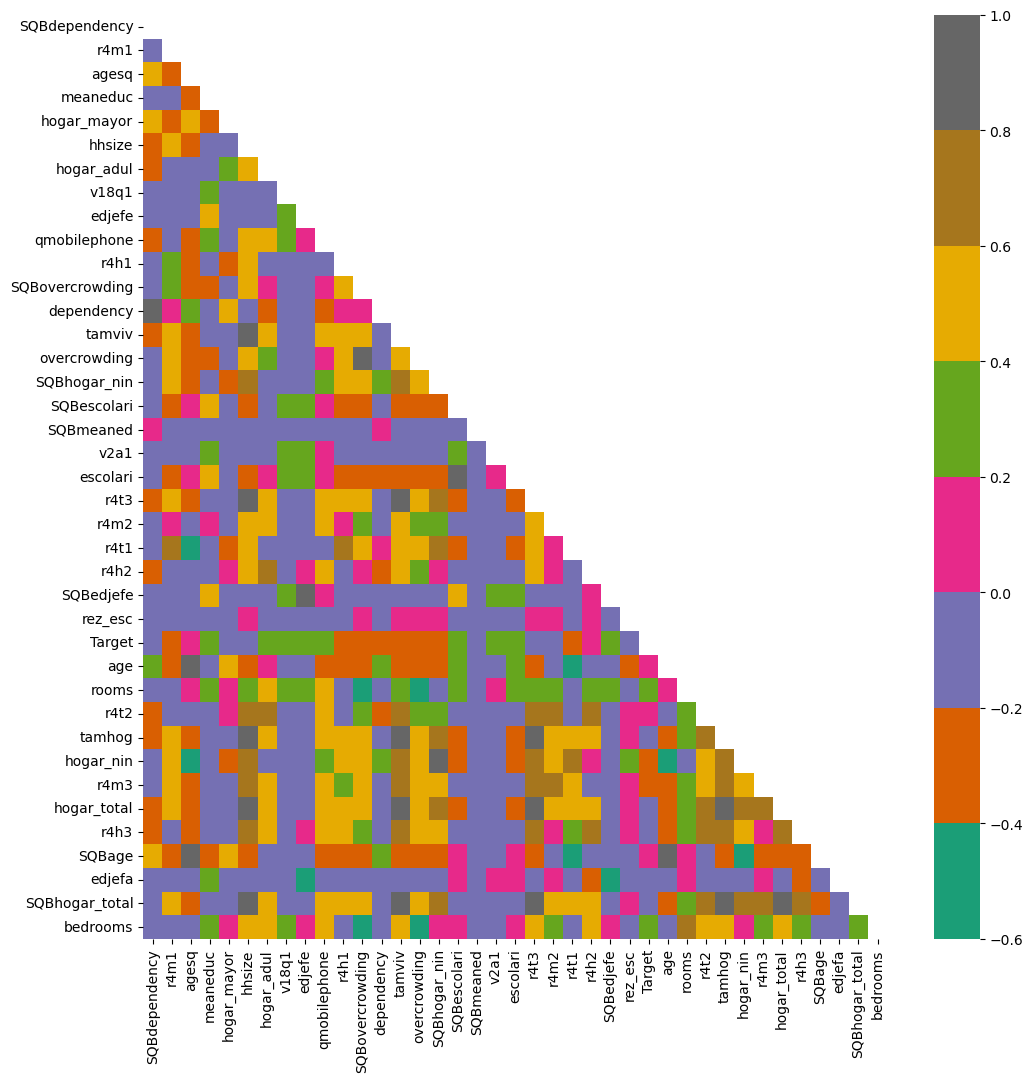

In [49]:
# Plotting correlation heatmap

plt.figure(figsize=(12,12))
corr = X0[remaining_vars].corr().round(1)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='Dark2')
plt.show()

The correlation heatmap is overcrowded.

In [50]:
# let's investigate the correlation results in a table

corr.sort_values(by='Target', ascending=False).style.background_gradient(cmap = 'bwr')

,SQBdependency,r4m1,agesq,meaneduc,hogar_mayor,hhsize,hogar_adul,v18q1,edjefe,qmobilephone,r4h1,SQBovercrowding,dependency,tamviv,overcrowding,SQBhogar_nin,SQBescolari,SQBmeaned,v2a1,escolari,r4t3,r4m2,r4t1,r4h2,SQBedjefe,rez_esc,Target,age,rooms,r4t2,tamhog,hogar_nin,r4m3,hogar_total,r4h3,SQBage,edjefa,SQBhogar_total,bedrooms
Target,-0.100000,-0.300000,0.100000,0.300000,-0.000000,-0.100000,0.200000,0.200000,0.200000,0.200000,-0.200000,-0.300000,-0.200000,-0.200000,-0.300000,-0.300000,0.300000,0.000000,0.200000,0.300000,-0.100000,-0.000000,-0.300000,0.100000,0.200000,-0.100000,1.000000,0.100000,0.200000,0.100000,-0.100000,-0.300000,-0.200000,-0.100000,-0.000000,0.100000,0.000000,-0.100000,0.200000
escolari,-0.100000,-0.200000,0.100000,0.500000,-0.000000,-0.200000,0.100000,0.200000,0.300000,0.100000,-0.200000,-0.200000,-0.200000,-0.200000,-0.300000,-0.200000,0.900000,0.000000,0.100000,1.000000,-0.200000,0.000000,-0.300000,0.000000,0.300000,-0.100000,0.300000,0.200000,0.200000,0.000000,-0.200000,-0.300000,-0.100000,-0.200000,-0.100000,0.100000,0.100000,-0.100000,0.100000
meaneduc,-0.100000,-0.000000,-0.200000,1.000000,-0.200000,-0.000000,-0.100000,0.300000,0.400000,0.200000,-0.100000,-0.200000,-0.100000,-0.000000,-0.200000,-0.000000,0.600000,0.000000,0.300000,0.500000,-0.000000,0.100000,-0.100000,-0.000000,0.500000,-0.100000,0.300000,-0.100000,0.300000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.100000,-0.200000,0.300000,-0.000000,0.200000
SQBescolari,-0.000000,-0.200000,0.100000,0.600000,-0.000000,-0.200000,0.000000,0.200000,0.300000,0.100000,-0.200000,-0.200000,-0.100000,-0.200000,-0.200000,-0.200000,1.000000,0.000000,0.200000,0.900000,-0.200000,0.000000,-0.200000,-0.000000,0.400000,-0.100000,0.300000,0.200000,0.200000,-0.000000,-0.200000,-0.200000,-0.100000,-0.200000,-0.100000,0.100000,0.100000,-0.100000,0.100000
qmobilephone,-0.200000,0.000000,-0.200000,0.200000,-0.100000,0.500000,0.500000,0.200000,0.100000,1.000000,0.000000,0.100000,-0.200000,0.600000,0.100000,0.200000,0.100000,-0.000000,0.100000,0.100000,0.500000,0.500000,0.000000,0.500000,0.100000,0.000000,0.200000,-0.200000,0.400000,0.600000,0.500000,0.200000,0.400000,0.500000,0.400000,-0.200000,-0.000000,0.500000,0.500000
rooms,-0.000000,-0.000000,0.100000,0.300000,0.100000,0.200000,0.400000,0.300000,0.200000,0.400000,-0.100000,-0.400000,-0.000000,0.300000,-0.400000,0.000000,0.200000,-0.000000,0.100000,0.200000,0.200000,0.200000,-0.100000,0.300000,0.200000,-0.000000,0.200000,0.100000,1.000000,0.300000,0.200000,-0.000000,0.200000,0.200000,0.200000,0.100000,0.100000,0.200000,0.800000
SQBedjefe,-0.000000,-0.000000,-0.000000,0.500000,-0.100000,-0.000000,-0.000000,0.300000,0.900000,0.100000,-0.000000,-0.100000,-0.100000,-0.000000,-0.100000,-0.000000,0.400000,0.000000,0.300000,0.300000,-0.000000,-0.100000,-0.000000,0.100000,1.000000,-0.100000,0.200000,-0.000000,0.200000,-0.000000,-0.000000,-0.000000,-0.100000,-0.000000,0.000000,-0.000000,-0.400000,-0.000000,0.100000
v2a1,-0.100000,0.000000,-0.100000,0.300000,-0.100000,-0.000000,-0.100000,0.200000,0.200000,0.100000,0.000000,-0.000000,-0.100000,-0.000000,-0.000000,0.000000,0.200000,0.000000,1.000000,0.100000,-0.000000,0.000000,0.000000,-0.100000,0.300000,-0.000000,0.200000,-0.100000,0.100000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.100000,0.100000,-0.000000,0.000000
bedrooms,-0.100000,-0.000000,0.000000,0.200000,0.100000,0.400000,0.500000,0.200000,0.100000,0.500000,-0.000000,-0.400000,-0.100000,0.400000,-0.400000,0.100000,0.100000,-0.000000,0.000000,0.100000,0.400000,0.300000,-0.000000,0.400000,0.100000,-0.000000,0.200000,0.000000,0.800000,0.500000,0.400000,0.100000,0.200000,0.400000,0.300000,0.000000,0.000000,0.300000,1.000000
edjefe,-0.100000,-0.000000,-0.000000,0.400000,-0.100000,-0.000000,0.000000,0.300000,1.000000,0.100000,-0.000000,-0.100000,-0.100000,-0.000000,-0.100000,-0.100000,0.300000,0.000000,0.200000,0.300000,-0.000000,-0.100000,-0.000000,0.100000,0.900000,-0.100000,0.200000,-0.000000,0.20

KEY OBSERVATIONS:
- There is very strong correlation between several variables. In fact many of them are practically same e.g.
 * hogar_total - Number of total individuals in the household
 * tamviv - number of persons living in the household
 * tamhog - size of the household
 * hhsize - household size
 * r4t3 - Total persons in the household
 * Many of the variables are merely squared values of other variables and hence strongly correlated e.g.
        # SQBhogar_total - hogar_total squared
        # SQBage, agesq, age
        # SQBescolari and escolari
        # SQBhogar_nin and hogar_nin
        # SQBdependency and dependency
        # SQBovercrowding and overcrowding
 * Interestingly none of these variables is strongly correlated to the 'Target'/ response variable.
        # Variables related to education i.e. meaneduc, escolari and SQBescolari have strongest correlation (0.3) with 
        # Target. 
        # Similarly, variables relates to number of members below 18/19 has strongest -ve correlation (-0.3) wth Target e.g
        # hogar_nin, r4t1 and SQBhogar_nin
    
Given these observations, the key question is - does these highly correlated variables improve/ adversely affect model performance in any way?

In [51]:
# Let's create two datasets X0, X1. These will have same number of rows but different number of columns.
# Also, let's drop 'object' dtype columns i.e. 'Id' and 'idhogar' for model building.

X0.drop(['Id', 'idhogar'], axis=1, inplace=True)
X0.shape  # This set has all the rows and columns

X1 = X0.drop(['v18q1', 'rez_esc', 'v2a1', 'hogar_total', 'tamviv', 'tamhog', 'r4t3', 'SQBhogar_total', 'SQBage', 'agesq',
              'SQBescolari', 'hogar_nin', 'SQBovercrowding', 'SQBdependency'], axis=1)
X1.shape  # This is same as X0 except columns with large number of Null values and multi-colinearity have been droped 

(9557, 141)

(9557, 127)

NOTE: The Random Forest Classifier (algorithm) works on information gain and entropy which are independent of absolute values of the features, it is not sensitive to outliers and doesn't need feature scaling.

In [52]:
# Creating train_test_splits

# For Model0
y0 = X0.Target
X0 = X0.drop('Target', axis=1)
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.4, shuffle=True, stratify=y0, random_state=81)
print('The shape of X0 splits is as below:')
print(f'X0_train shape: {X0_train.shape}')
print(f'X0_test shape: {X0_test.shape}')
print(f'y0_train shape: {y0_train.shape}')
print(f'y0_test shape: {y0_test.shape}\n')


# For Model1
y1 = X1.Target
X1 = X1.drop('Target', axis=1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, shuffle=True, stratify=y1, random_state=81)
print('The shape of X1 splits is as below:')
print(f'X1_train shape: {X1_train.shape}')
print(f'X1_test shape: {X1_test.shape}')
print(f'y1_train shape: {y1_train.shape}')
print(f'y1_test shape: {y1_test.shape}\n')

The shape of X0 splits is as below:
X0_train shape: (5734, 140)
X0_test shape: (3823, 140)
y0_train shape: (5734,)
y0_test shape: (3823,)

The shape of X1 splits is as below:
X1_train shape: (5734, 126)
X1_test shape: (3823, 126)
y1_train shape: (5734,)
y1_test shape: (3823,)



In [53]:
# Creating pipeline from imblearn package (Not using pipeline from sklearn.pipeline)

pipe = make_pipeline_imb(StandardScaler(), SMOTE(random_state=81), RandomForestClassifier(random_state=81))

In [54]:
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('smote', SMOTE(random_state=81)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=81))])

In [55]:
# Creating two base models: 
# MODEL0


# Model building
rf_mod0 = pipe.fit(X0_train, y0_train)

# Prediction using the model
y0_pred = rf_mod0.predict(X0_test)

# Model accuracy
print("MODEL0\n")
print(f'Train Accuracy score: {round(accuracy_score(y0_train, rf_mod0.predict(X0_train)), 3)}')
print(f'Test Accuracy score: {round(accuracy_score(y0_test, y0_pred), 3)}\n')

# Model evaluation using Confusion Matrix and Classification Report
print("Confusion Matrix:")
cm0 = confusion_matrix(y0_test, y0_pred)
print(cm0)

print('\n')
print('Classification Report:')
cr0 = classification_report(y0_test, y0_pred)
print(cr0)

MODEL0

Train Accuracy score: 1.0
Test Accuracy score: 0.917

Confusion Matrix:
[[ 242   11    3   40]
 [  13  542    8   80]
 [   5   17  361  102]
 [   4   17   19 2359]]


Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.82      0.86       296
           2       0.92      0.84      0.88       643
           3       0.92      0.74      0.82       485
           4       0.91      0.98      0.95      2399

    accuracy                           0.92      3823
   macro avg       0.92      0.85      0.88      3823
weighted avg       0.92      0.92      0.91      3823



In [56]:
# MODEL1


# Model building
rf_mod1 = pipe.fit(X1_train, y1_train)

# Prediction using the model
y1_pred = rf_mod1.predict(X1_test)

# Model accuracy
print("MODEL1\n")
print(f'Train Accuracy score: {round(accuracy_score(y1_train, rf_mod1.predict(X1_train)), 3)}')
print(f'Accuracy score: {round(accuracy_score(y1_test, y1_pred), 3)}\n')

# Model evaluation using Confusion Matrix and Classification Report
print("Confusion Matrix:")
cm1 = confusion_matrix(y1_test, y1_pred)
print(cm1)

print('\n')
print('Classification Report:')
cr1 = classification_report(y1_test, y1_pred)
print(cr1)

MODEL1

Train Accuracy score: 1.0
Accuracy score: 0.92

Confusion Matrix:
[[ 240   14    5   37]
 [   8  550   10   75]
 [   1   18  365  101]
 [   3   21   13 2362]]


Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.81      0.88       296
           2       0.91      0.86      0.88       643
           3       0.93      0.75      0.83       485
           4       0.92      0.98      0.95      2399

    accuracy                           0.92      3823
   macro avg       0.93      0.85      0.88      3823
weighted avg       0.92      0.92      0.92      3823



CONCLUSIONS: Several interesting conclusion can be drawn
- For both Model0 and Model1, train accuracy score is 1.0 !!! Is this a case of over-fitting? The model seems to have learnt the entire data/pattern
- The test accuracy score (approx. 92%) too is good for both the models. A good test accuracy score indicates the model performance is good (no overfitting).
- Accuracy - can be misleading metrics, so looking at classification report we can conclude both models have good precision and recall scores for all four classes. This further reassures that both models performance is indeed good and have no bias towards any one particular class.
- Droping various columns from the dataset had little impact on the overall perfomance of the model i.e. Model1's performance is similar to Model0.
- Model performance must be further vetted using cross-validation
           
Random Forest Classifier model has good performance for the given dataset. Both the precision and recall score are resonably good for all the four classes

#### Checking XGBClassifier and Random forest model performance with cross validation

For this task we will use complete dataset i.e. Model0 dataset will be used

In [57]:
# Instantiating models to be created and cross-validated
classifiers = [RandomForestClassifier(random_state=81),
               XGBClassifier(use_label_encoder=False)
              ]

# Using Stratified KFold cross-validation
n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=81)
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted')
          } 


# Performing cross-validation
CV_results = []

for clf in classifiers:
    pipe = make_pipeline_imb(SMOTE(random_state=81), clf)
    cv_result = cross_validate(pipe, X0, y0-1, cv=skf, scoring=scoring, return_train_score=True, return_estimator=True)
    CV_results.append(cv_result)
    
# NOTE the use of y0-1 as Target data for modelling (instead of y0). This is done as Starting in XGBoost 1.3.0 class labels
# has to be int starting with Zero. Our dataset has class labels 1, 2, 3 & 4 i.e not starting from Zero.    

In [58]:
# CV_Results is a list of cross-validation result dictionaries for RF Classifier and XGB Classifier.
# Dispalying keys of the RF Classifier model pipeline

CV_results[0].keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_precision', 'train_precision', 'test_recall', 'train_recall'])

In [59]:
# Creating dataframes to display results from Cross-Validation

fold = [('fold_' + str(i)) for i in range(n_splits)]
Results = {'RFC_Result': 0, 'XGBC_Result': 1}

for i in Results:
    Results[i] = pd.DataFrame({'Fold': fold,
                               'Train Accuracy': CV_results[Results[i]]['train_accuracy'],
                               'Test Accuracy': CV_results[Results[i]]['test_accuracy'],
                               'Train Precision': CV_results[Results[i]]['train_precision'],
                               'Test Precision': CV_results[Results[i]]['test_precision'],
                               'Train Recall': CV_results[Results[i]]['train_recall'],
                               'Test Recall': CV_results[Results[i]]['test_recall']
                              })

In [60]:
# Printing Cross-Validation Results 

print(f'RANDOM FOREST CLASSIFIER: Cross-Validation Result\n')
print(Results['RFC_Result'].round(3).sort_values(by='Test Recall'))
print("\n")
print('Mean and standard deviation are as below:')
print(Results['RFC_Result'].set_index('Fold').aggregate(['mean', 'std']).round(3))

print("\n")
print(f'XGBOOST CLASSIFIER: Cross-Validation Result\n')
print(Results['XGBC_Result'].round(3).sort_values(by='Test Recall'))
print("\n")
print('Mean and standard deviation are as below:')
print(Results['XGBC_Result'].set_index('Fold').agg(['mean', 'std']).round(3))

RANDOM FOREST CLASSIFIER: Cross-Validation Result

     Fold  Train Accuracy  Test Accuracy  Train Precision  Test Precision  \
2  fold_2             1.0          0.945              1.0           0.947   
1  fold_1             1.0          0.947              1.0           0.948   
6  fold_6             1.0          0.947              1.0           0.948   
4  fold_4             1.0          0.948              1.0           0.948   
0  fold_0             1.0          0.951              1.0           0.952   
5  fold_5             1.0          0.954              1.0           0.955   
3  fold_3             1.0          0.960              1.0           0.960   

   Train Recall  Test Recall  
2           1.0        0.945  
1           1.0        0.947  
6           1.0        0.947  
4           1.0        0.948  
0           1.0        0.951  
5           1.0        0.954  
3           1.0        0.960  


Mean and standard deviation are as below:
      Train Accuracy  Test Accuracy  Tra

In [61]:
# Using Trained RF Classifier to make predictions. We will use test dataset for this

# Step 0 - Check shape of test data
test.shape

# Step 1 - Data Cleaning by calling the data_cleaner() func defined earlier
test_data = data_cleaner(test)
test_data.shape

(23856, 142)

(23853, 142)

In [62]:
# Step 2 - Setting the household head for households without an identified head
df = test_data.groupby('idhogar').filter(lambda x: (x['parentesco1'] == 0).all())
test_data.loc[df.groupby('idhogar').age.idxmax(), 'parentesco1'] = 1

In [63]:
# Step 3 - Droping 'Id' and 'idhogar' columns for model building
test_data_dropped_cols = test_data.loc[:,['Id', 'idhogar']]
test_data.drop(['Id', 'idhogar'], axis=1, inplace=True)

# NOTE: Step 2 and step 3 could be combined in data_cleaner function

NOTE:
- Here CV_results is list cross-validation result dictionaries. Index 0 corresponds to Random Forest Classifier Model.
- 'estimator' is the dictionary key for a list of all fitted models. Post observing the Cross-Validation results, we found that fold_3 has the best Precision and Recall. Therefore the same fitted model has been used for prediction.

In [64]:
# Making prediction using the classifier model.

y_pred = CV_results[0]['estimator'][3].predict(test_data)
len(y_pred)

23853

In [65]:
# Creating a test_prediciton dataframe to display predicted class
test_prediction = pd.concat([test_data_dropped_cols, test_data, pd.Series(y_pred+1, name='Target')], axis=1)
test_prediction.shape

(23853, 143)

In [66]:
# Taking a look at first five rows of test_prediction
test_prediction.head()

,Id,idhogar,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_2f6873615,72958b30c,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,0,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,0,3,0.5,0,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,2.722500e+02,16,4
1,ID_1c78846d2,72958b30c,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,16,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0,3,0.5,0,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,2.722500e+02,1681,4
2,ID_e5442cf6a,72958b30c,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,3,17,0.0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,3,0.5,0,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,2.722500e+02,1681,4
3,ID_a8db26a79,5b598fbc9,0.0,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.0,16,0,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,2.560000e+02,3481,4
4,ID_a62966799,1e2fc704e,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,8.0,0,11,11.0,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,2.853117e+11,324,4


In [67]:
# Finally the count of different class predictions
test_prediction.Target.value_counts()

Target
4    16756
2     4395
3     1664
1     1038
Name: count, dtype: int64

#### ------------------------------------------------------------------------  End of the Project  --------------------------------------------------------------------------------